# **Stock Market Volatility Prediction with Event-Driven Sentiment Analysis**

## **Table of Contents**
*   [Introduction](#introduction)
*   [Data Retrieval and Preprocessing](#data-retrieval-and-preprocessing)
    - [Historical Stock Data Retrieval](#historical-stock-data-retrieval)
    - [Financial News Articles Retrieval](#financial-news-articles-retrieval)
    - [Sentiment Analysis](#sentiment-analysis)
*   [Feature Engineering](#feature-engineering)
    - [Adding Technical Indicators](#adding-technical-indicators)
*   [Data Preparation for Modeling](#data-preparation-for-modeling)
    - [Scaling Features](#scaling-features)
    - [Preparing Data for LSTM](#preparing-data-for-lstm)
*   [Model Construction and Training](#model-construction-and-training)
    - [LSTM Model Architecture](#lstm-model-architecture)
    - [Training the Model](#training-the-model)
*   [Model Evaluation](#model-evaluation)
    - [Predictions and Inverse Scaling](#predictions-and-inverse-scaling)
    - [Performance Metrics](#performance-metrics)
    - [Residual Analysis](#residual-analysis)
*   [Visualization](#visualization)
    - [Plotting Predictions vs Actual Volatility](#plotting-predictions-vs-actual-volatility)
    - [Interactive Dashboard](#interactive-dashboard)
*   [Conclusion and Future Work](#conclusion)

---

<a name='introduction'></a>
## **Introduction**

In today's fast-paced financial world, investors, analysts, and financial institutions rely heavily on stock market volatility predictions. Volatility is the degree of fluctuation in a trading price series over time and is an important factor in risk management and trading techniques. Traditional models frequently depend simply on past price data, which may fail to incorporate current market sentiments and exogenous events that impact investor behaviour.


With the development of powerful Natural Language Processing (NLP) techniques and the availability of massive volumes of textual data, adding sentiment analysis from financial news into volatility prediction models has emerged as a potential option. This research tries to improve volatility prediction by combining sentiment ratings from recent financial news items with historical stock data.


---

**Objective**: To forecast stock market volatility using historical stock data and sentiment analysis from current financial news items.

---

In [1]:
!pip install dash plotly scikit-learn statsmodels ta tensorflow yfinance

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 24.3 MB/s eta 0:00:00
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=55d57df34aebd37d24ddea46bf76211da56aa2bf784fcb312c343ea837ec2649
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [2]:
import dash
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import requests
import seaborn as sns
import yfinance as yf

from dash import dcc, html, Input, Output
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import ExponentialSmoothing
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from transformers import pipeline


In [3]:
sns.set(style="whitegrid")
plt.style.use("fivethirtyeight")
pd.set_option("display.max_columns", None)


api_key = "api_key"
end_date = "2024-11-09"
start_date = "2024-10-09"
ticker = "NVDA"
ticker_name = "NVIDIA"
ticker_start_date = "2024-01-01"


---

<a name='data-retrieval-and-preprocessing'></a>
## **Data Retrieval and Preprocessing**

Prior to model development, gathering and preprocessing the necessary data is essential.

---

<a name='historical-stock-data-retrieval'></a>
### **Historical Stock Data Retrieval**

The `yfinance` library is used to fetch historical stock data for NVIDIA Corporation (NVDA).

---

In [4]:
def fetch_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data['Return'] = data['Close'].pct_change()
    data['Volatility'] = data['Return'].rolling(window=5).std()
    data.dropna(inplace=True)
    return data


stock_data = fetch_stock_data(ticker, ticker_start_date, end_date)
stock_data.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume,Return,Volatility
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA,,
Date,,,,,,,,
2024-01-09 00:00:00+00:00,53.128601,53.139999,54.325001,51.689999,52.401001,773100000,0.016975,0.028066
2024-01-10 00:00:00+00:00,54.338341,54.349998,54.599998,53.488998,53.616001,533796000,0.022770,0.021496
2024-01-11 00:00:00+00:00,54.810238,54.821999,55.346001,53.560001,54.999001,596759000,0.008684,0.021567
2024-01-12 00:00:00+00:00,54.698257,54.709999,54.970001,54.330002,54.619999,352994000,-0.002043,0.025342
2024-01-16 00:00:00+00:00,56.369904,56.382000,56.834999,54.900002,55.018002,449580000,0.030561,0.012610


---

<a name='financial-news-articles-retrieval'></a>
### **Financial News Articles Retrieval**

Recent news articles related to NVIDIA are retrieved using the NewsAPI.


---

In [5]:
def fetch_news_articles(api_key, ticker_name, from_date, to_date):
    url = f"https://newsapi.org/v2/everything?q={ticker_name}&from={from_date}&to={to_date}&sortBy=popularity&apiKey={api_key}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        articles = response.json().get("articles", [])
        if articles:
            news_data = pd.DataFrame(
                [(article['publishedAt'], f"{article.get('title', '')} {article.get('description', '')}")
                 for article in articles],
                columns=["date", "content"]
            )
            news_data['date'] = pd.to_datetime(news_data['date']).dt.date
            return news_data
        else:
            print("No articles found for the given parameters.")
            return pd.DataFrame(columns=["date", "content"])
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred: {http_err}")
        return pd.DataFrame(columns=["date", "content"])
    except Exception as err:
        print(f"An error occurred: {err}")
        return pd.DataFrame(columns=["date", "content"])


news_data = fetch_news_articles(api_key, ticker_name, start_date, end_date)
news_data.head()


,date,content
0,2024-11-07,NVIDIA will add a monthly playtime cap to GeFo...
1,2024-10-30,AMD's next-gen GPUs are set to arrive in early...
2,2024-10-09,18 Best Prime Day Laptop Deals (2024) From Mac...
3,2024-11-05,Steam’s built-in game recording is now availab...
4,2024-11-07,"Clearly Hard Up for Cash, Nvidia to Limit GeFo..."


---

<a name='sentiment-analysis'></a>
### **Sentiment Analysis**

Sentiment analysis is performed on the news content using a pre-trained BERT model.

---

In [6]:
def perform_sentiment_analysis(news_df):
    sentiment_pipeline = pipeline("sentiment-analysis", model="yiyanghkust/finbert-tone")
    news_df['sentiment'] = news_df['content'].apply(lambda x: sentiment_pipeline(x)[0])
    news_df['sentiment_label'] = news_df['sentiment'].apply(lambda x: x['label'])
    news_df['sentiment_score'] = news_df['sentiment'].apply(lambda x: x['score'])
    news_df['sentiment_numeric'] = news_df['sentiment_label'].apply(lambda x: 1 if x == 'POSITIVE' else -1)
    news_df['sentiment_score'] = news_df['sentiment_score'] * news_df['sentiment_numeric']
    sentiment_by_date = news_df.groupby('date').agg({'sentiment_score': 'mean'}).rename(columns={'sentiment_score': 'avg_sentiment'}).reset_index()
    return sentiment_by_date

sentiment_by_date = perform_sentiment_analysis(news_data)
sentiment_by_date.head()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


,date,avg_sentiment
0,2024-10-09,-0.999857
1,2024-10-10,-0.902439
2,2024-10-11,-0.908443
3,2024-10-12,-0.999939
4,2024-10-13,-0.999820


---

<a name='feature-engineering'></a>
## **Feature Engineering**

The dataset is enhanced by adding technical indicators and merging it with sentiment scores.

---

<a name='adding-technical-indicators'></a>
### **Adding Technical Indicators**

Additional technical indicators, such as Moving Averages, Exponential Moving Average, Momentum, Bollinger Bands, and RSI, are calculated.

---


In [7]:
def add_technical_indicators(data, ticker):
    data['MA5'] = data[f'Close_{ticker}'].rolling(window=5).mean()
    data['MA10'] = data[f'Close_{ticker}'].rolling(window=10).mean()
    data['EMA'] = data[f'Close_{ticker}'].ewm(span=5, adjust=False).mean()
    data['Momentum'] = data[f'Close_{ticker}'] - data[f'Close_{ticker}'].shift(4)
    indicator_bb = BollingerBands(close=data[f'Close_{ticker}'], window=20, window_dev=2)
    data['BB_High'] = indicator_bb.bollinger_hband()
    data['BB_Low'] = indicator_bb.bollinger_lband()
    indicator_rsi = RSIIndicator(close=data[f'Close_{ticker}'], window=14)
    data['RSI'] = indicator_rsi.rsi()
    return data

stock_data.columns = ['_'.join(filter(None, col)).strip() for col in stock_data.columns.values]
stock_data = add_technical_indicators(stock_data, ticker)
stock_data.reset_index(inplace=True)
stock_data['date'] = stock_data['Date'].dt.date
stock_data = pd.merge(stock_data, sentiment_by_date, on='date', how='left')
stock_data['avg_sentiment'].fillna(0, inplace=True)
start_date_filter = "2024-10-09"
stock_data = stock_data[stock_data['Date'] >= start_date_filter].reset_index(drop=True)
stock_data.head()


<ipython-input-7-e18045894c7c>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stock_data['avg_sentiment'].fillna(0, inplace=True)


,Date,Adj Close_NVDA,Close_NVDA,High_NVDA,Low_NVDA,Open_NVDA,Volume_NVDA,Return,Volatility,MA5,MA10,EMA,Momentum,BB_High,BB_Low,RSI,date,avg_sentiment
0,2024-10-09 00:00:00+00:00,132.649994,132.649994,134.520004,131.380005,134.110001,246191600,-0.001806,0.016357,128.205998,124.375999,128.834777,9.799995,131.571475,110.653525,65.657626,2024-10-09,-0.999857
1,2024-10-10 00:00:00+00:00,134.809998,134.809998,135.000000,131.000000,131.910004,242311300,0.016283,0.015147,130.597998,125.452999,130.826517,9.889999,133.882693,109.909307,67.573091,2024-10-10,-0.902439
2,2024-10-11 00:00:00+00:00,134.800003,134.800003,135.779999,133.660004,134.009995,170209500,-0.000074,0.017424,132.573999,126.792999,132.151012,7.080002,135.832238,109.529763,67.554315,2024-10-11,-0.908443
3,2024-10-14 00:00:00+00:00,138.070007,138.070007,139.600006,136.300003,136.470001,232347700,0.024258,0.017627,134.644000,128.456000,134.124011,5.180008,138.196187,109.294814,70.447527,2024-10-14,-0.965409
4,2024-10-15 00:00:00+00:00,131.600006,131.600006,138.570007,128.740005,137.869995,377831000,-0.046860,0.027565,134.386002,129.916000,133.282676,-1.049988,138.874132,110.217870,59.199376,2024-10-15,-0.999940


---

<a name='data-preparation-for-modeling'></a>
## **Data Preparation for Modeling**

---

<a name='scaling-features'></a>
### **Scaling Features**

Feature scaling ensures equal contribution to model training by different variables.

---


In [8]:
features = ['Volatility', 'avg_sentiment', 'MA5', 'MA10', 'EMA', 'Momentum', 'BB_High', 'BB_Low', 'RSI']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(stock_data[features])
scaled_stock_data = pd.DataFrame(scaled_features, columns=features)
scaled_stock_data['Date'] = stock_data['Date'].values
scaled_stock_data.set_index('Date', inplace=True)
scaled_stock_data.head()


,Volatility,avg_sentiment,MA5,MA10,EMA,Momentum,BB_High,BB_Low,RSI
Date,,,,,,,,,
2024-10-09,-0.898924,-0.349262,-2.493952,-2.173991,-2.226201,1.059163,-2.429600,-1.027083,0.459147
2024-10-10,-1.070124,0.134969,-1.852275,-1.965678,-1.716359,1.073612,-1.964465,-1.118775,0.815063
2024-10-11,-0.747953,0.105122,-1.322194,-1.706495,-1.377317,0.622516,-1.572116,-1.165537,0.811574
2024-10-14,-0.719323,-0.178032,-0.766896,-1.384837,-0.872273,0.317506,-1.096368,-1.194485,1.349167
2024-10-15,0.686963,-0.349674,-0.836106,-1.102444,-1.087636,-0.682609,-0.959931,-1.080758,-0.740872


---

<a name='preparing-data-for-lstm'></a>
### **Preparing Data for LSTM**

Data is prepared in a format suitable for LSTM models.

---

In [9]:
def prepare_data_lstm(data, target_column, window_size=5):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i-window_size:i].values)
        y.append(data.iloc[i][target_column])
    return np.array(X), np.array(y)

window_size = 5
target_column = 'Volatility'
X, y = prepare_data_lstm(scaled_stock_data, target_column, window_size)


---

<a name='model-construction-and-training'></a>
## **Model Construction and Training**

---

<a name='lstm-model-architecture'></a>
### **LSTM Model Architecture**

An LSTM model with additional layers is constructed to capture the temporal dependencies in the data.

---


In [10]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(64))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model


input_shape = (X.shape[1], X.shape[2])
model = build_lstm_model(input_shape)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


---

<a name='training-the-model'></a>
### **Training the Model**

The model is trained, and the training and validation loss are visualized.

---

Epoch 1/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.9657 - val_loss: 1.5108
Epoch 2/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.8668 - val_loss: 1.5393
Epoch 3/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.7705 - val_loss: 1.5712
Epoch 4/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.7040 - val_loss: 1.6018
Epoch 5/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.6140 - val_loss: 1.6323
Epoch 6/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.5759 - val_loss: 1.6559
Epoch 7/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.5418 - val_loss: 1.6699
Epoch 8/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.5213 - val_loss: 1.6708
Epoch 9/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.5348 - val_loss: 1.6573
Epoch 10/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.5060 - val_loss: 1.6311
Epoch 11/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.5209 - val_loss: 1.5925
Epoch 12/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.4422 - val_l

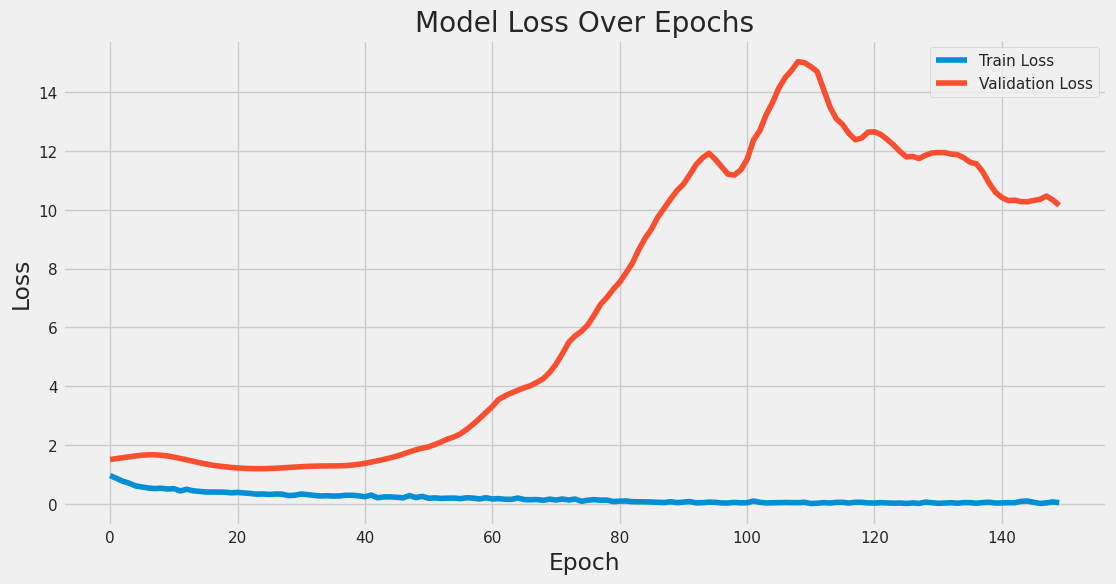

In [11]:
history = model.fit(X, y, epochs=150, batch_size=16, validation_split=0.2, verbose=1)


plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


---

<a name='model-evaluation'></a>
## **Model Evaluation**

---

<a name='predictions-and-inverse-scaling'></a>
### **Predictions and Inverse Scaling**

Predictions are made, and the scaled data is inverse-transformed to obtain the actual values.

---


In [12]:
predicted_volatility = model.predict(X)

def inverse_transform(predictions, y_true, scaler, target_column_index):
    extended_predictions = np.zeros((predictions.shape[0], scaler.mean_.shape[0]))
    extended_predictions[:, target_column_index] = predictions[:, 0]
    extended_y_true = np.zeros((y_true.shape[0], scaler.mean_.shape[0]))
    extended_y_true[:, target_column_index] = y_true
    inv_predictions = scaler.inverse_transform(extended_predictions)[:, target_column_index]
    inv_y_true = scaler.inverse_transform(extended_y_true)[:, target_column_index]
    return inv_predictions, inv_y_true


target_column_index = features.index(target_column)
inv_predictions, inv_y_true = inverse_transform(predicted_volatility, y, scaler, target_column_index)
forecast_data = pd.DataFrame({
    'Date': scaled_stock_data.index[window_size:],
    'True_Volatility': inv_y_true,
    'Predicted_Volatility': inv_predictions
})
forecast_data.set_index('Date', inplace=True)
forecast_data.head()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


,True_Volatility,Predicted_Volatility
Date,,
2024-10-16,0.031247,0.030955
2024-10-17,0.030751,0.031589
2024-10-18,0.030723,0.032399
2024-10-21,0.034156,0.032843
2024-10-22,0.017778,0.021262


---

<a name='performance-metrics'></a>
### **Performance Metrics**

The model's performance is evaluated using Mean Squared Error (MSE), Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R-squared.

---


In [13]:
mse = mean_squared_error(forecast_data['True_Volatility'], forecast_data['Predicted_Volatility'])
mae = mean_absolute_error(forecast_data['True_Volatility'], forecast_data['Predicted_Volatility'])
rmse = np.sqrt(mse)
r_squared = r2_score(forecast_data['True_Volatility'], forecast_data['Predicted_Volatility'])

print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"R-Squared: {r_squared:.6f}")


Mean Squared Error (MSE): 0.000114
Mean Absolute Error (MAE): 0.005746
Root Mean Squared Error (RMSE): 0.010684
R-Squared: -1.156226


---

<a name='residual-analysis'></a>
### **Residual Analysis**

Residuals are analyzed to further assess model performance.

---

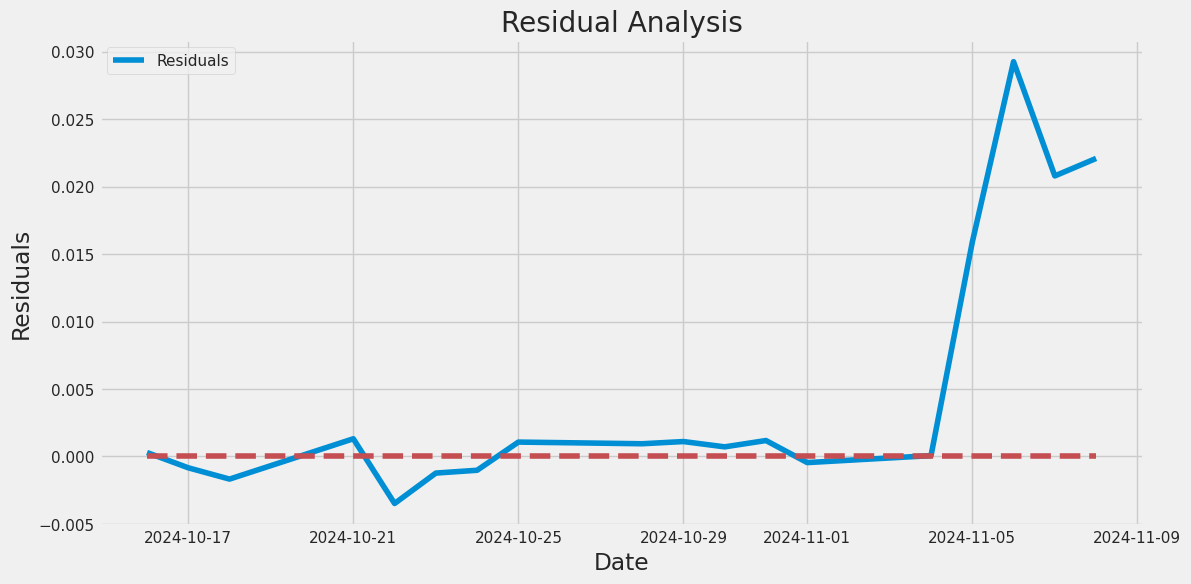

In [14]:
forecast_data['Residuals'] = forecast_data['True_Volatility'] - forecast_data['Predicted_Volatility']


plt.figure(figsize=(12, 6))
plt.plot(forecast_data['Residuals'], label='Residuals')
plt.hlines(0, xmin=forecast_data.index.min(), xmax=forecast_data.index.max(), colors='r', linestyles='--')
plt.title('Residual Analysis')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()


---

<a name='visualization'></a>
## **Visualization**

---

<a name='plotting-predictions-vs-actual-volatility'></a>
### **Plotting Predictions vs Actual Volatility**

Predicted and actual volatility over time is visualized.

---

In [15]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=forecast_data.index, y=forecast_data['True_Volatility'],
                         mode='lines+markers', name='True Volatility'))
fig.add_trace(go.Scatter(x=forecast_data.index, y=forecast_data['Predicted_Volatility'],
                         mode='lines+markers', name='Predicted Volatility'))
fig.update_layout(title='Stock Market Volatility Prediction',
                  xaxis_title='Date',
                  yaxis_title='Volatility',
                  xaxis_rangeslider_visible=True)
fig.show()


---

<a name='conclusion'></a>

### **Key Observations and Insights**

1. **Model Performance for Volatility Prediction**

   The model's ability to capture overall trends in market volatility has potential but requires refinement. The evaluation metrics—Mean Squared Error (MSE) of 0.000114, Mean Absolute Error (MAE) of 0.005746, and Root Mean Squared Error (RMSE) of 0.010684—show relatively effective forecasting of average daily volatility. However, the negative R-squared value of -1.156226 raises a serious concern, indicating that the model's explanatory power is extremely poor, worse than a horizontal line reflecting the data's mean. This poor fit could be attributed to the inherent complexity of market volatility, which frequently includes unanticipated occurrences, policy adjustments, and sentiment changes that are not fully reflected by the input features. Notably, the model's current limits may be influenced by the comparatively short dataset of only one month, implying that more extensive data could aid in performance. While the model detects broad patterns in volatility, it suffers greatly with abrupt swings, indicating a design that is insensitive to fast changes in market conditions.


2. **Training vs. Validation Loss Analysis**

   The training and validation loss study show a persistent disparity, with the training loss consistently smaller than the validation loss throughout all epochs. This suggests overfitting, which occurs when a model performs well on training data but fails to generalize effectively to new, previously unseen data. The plateau and subsequent increase in the validation loss support this observation, demonstrating that despite efforts to improve generalization, such as fine-tuning dropout rates, the model is still susceptible to overfitting. To overcome this, stronger regularization procedures and tweaks, such as early halting and higher dropout rates, may be useful in improving the model's robustness.

3. **Residual Analysis**

   The residual analysis reveals that the model maintains a consistent level of residuals near zero throughout stable market periods, implying no systematic bias. However, strong residual spikes, particularly during sharp market fluctuations or peaks, illustrate the model's difficulty in anticipating sudden changes in volatility. These bigger discrepancies indicate that, while the model can handle ordinary conditions, it struggles during high-volatility periods, which are frequently caused by unexpected events or external shocks. The consistent centering of residuals around zero during stable periods contributes to overall trend correctness, but the failure to handle volatility spikes highlights the limitations of the existing technique, particularly for high-impact, event-driven fluctuations.

4. **Effectiveness of Sentiment Integration**

   Integrating sentiment analysis from financial news has given the model an extra layer of insight, improving its capacity to detect mood-driven market patterns. This integration has allowed the model to better anticipate reactions to events that would not be obvious from past pricing data alone. However, the disparity between projected and actual volatility during high-volatility periods suggests that sentiment research alone is insufficient for forecasting unexpected, large-scale market moves. This could be due to delays in sentiment updates or sentiment scores' inability to completely capture complicated market-moving events. While sentiment data contributes to some degree of improvement, more real-time data sources and faster processing are required to properly catch rapid changes.

---

## **Conclusion**
Integrating sentiment analysis from financial news has given the model an extra layer of insight, improving its capacity to detect mood-driven market patterns. This integration has allowed the model to better anticipate reactions to events that would not be obvious from past pricing data alone. However, the disparity between projected and actual volatility during high-volatility periods suggests that sentiment research alone is insufficient for forecasting unexpected, large-scale market moves. This could be due to delays in sentiment updates or sentiment scores' inability to completely capture complicated market-moving events. While sentiment data contributes to some degree of improvement, more real-time data sources and faster processing are required to properly catch rapid changes.


Notwithstanding these difficulties, the model is a fundamental instrument for market analysis that blends technical and sentiment-driven insights. Significant improvements are required to make it a more accurate prediction tool, especially during times of increased market turbulence. These can involve using more sophisticated regularization techniques, improving the model architecture, and adding more varied data sources.

---

### **Future Directions and Recommendations**

1. **Including Additional Data Sources**

   Increasing the model's data sources could improve its capacity to capture the complexities of market movements. Integrating economic variables such as interest rates, inflation, and GDP growth can provide critical macroeconomic information. Including real-time social media sentiment (for example, Twitter mentions or sentiment research on hot stocks) may provide faster insights into public opinion shifts, thereby increasing responsiveness to breaking news. Furthermore, supplementing the present one-month dataset with more historical data is anticipated to improve model training and generalization, resulting in higher overall performance. Alternative datasets, such as options market data (implied volatility, put/call ratios), could assist the model better comprehend investor sentiment and future expectations, allowing it to predict volatility more correctly.

2. **Exploring Advanced Model Architectures**

   The capacity of the model to learn intricate temporal patterns may be improved by more complex neural network topologies, such as Transformer models, GRU networks, or bidirectional LSTMs. Transformers, which are well-known for their ability to model sequences, would be especially well-suited because of their self-attention processes, which allow the model to give priority to significant time steps and occurrences. Better prediction performance could result from this improvement, particularly when external causes and cumulative sentiment impact volatility trends.

3. **Improving Regularization and Hyperparameter Tuning**

   Overfitting still needs to be addressed, and other regularization strategies including higher dropout rates, L2 regularization, and early stopping must to be taken into account. Model performance can be further optimized with the use of more thorough hyperparameter tuning techniques like grid search, random search, or Bayesian optimization. The capacity of the model to adjust to new data without overfitting to the training set would be enhanced by a balanced approach to hyperparameter adjustment.

4. **Enhancing Model Interpretability**

   The features that have the greatest influence on the model's predictions can be revealed by using interpretability techniques such as SHAP (Shapley Additive Explanations) or LIME (Local Interpretable Model-agnostic Explanations). This could provide transparency, which is especially important in financial environments where decision-makers need to comprehend the reasoning behind forecasts, by elucidating the relative importance of sentiment scores, technical indicators, and historical data.

5. **Incorporating Advanced Technical Indicators**

   The model can more effectively detect short-term momentum shifts with the addition of other technical indicators such stochastic oscillators, volume-based metrics, and MACD (Moving Average Convergence Divergence). While stochastic oscillators can identify possible overbought or oversold situations, MACD can offer clues regarding the strength of a trend. By providing context for price changes and possibly increasing the accuracy of short-term volatility predictions, volume indicators can show the degree of market participation.


---
